# Data Cleaning and Wrangling Project

##### Using the Kaggle's Titanic Dataset

In [33]:
import pandas as pd
import numpy as np
import random
import re
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.model_selection import learning_curve, KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import datetime

# Introduction

This project is meant to showcase my data cleaning and data wrangling skills. I will be using the Titanic dataset from Kaggle.com. The description of this Kaggle challenge and the datasets used in this project can be found here: <a href="https://www.kaggle.com/competitions/titanic">The Titanic Dataset!</a><br><br>
The full Kaggle challenge involves predicting the survivors of the Titanic disaster contained in the test set by training a model on the outcomes of Titanic passengers in the labelled training set. In this notebook, I'll be focusing on strictly data cleaning and preparation of the data for usage in my model. With that, let's take a look at the dataset!

## A First Look at the Training Set

In [34]:
df_train = pd.read_csv("Titanic_Train_Original.csv", index_col = 0) # So the PassengerId Feature is used as row indices.
df_test = pd.read_csv("Titanic_Test_Original.csv", index_col = 0)

df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's explore the features of the training set using the data dictionary for this dataset written by the authors at Kaggle.com.

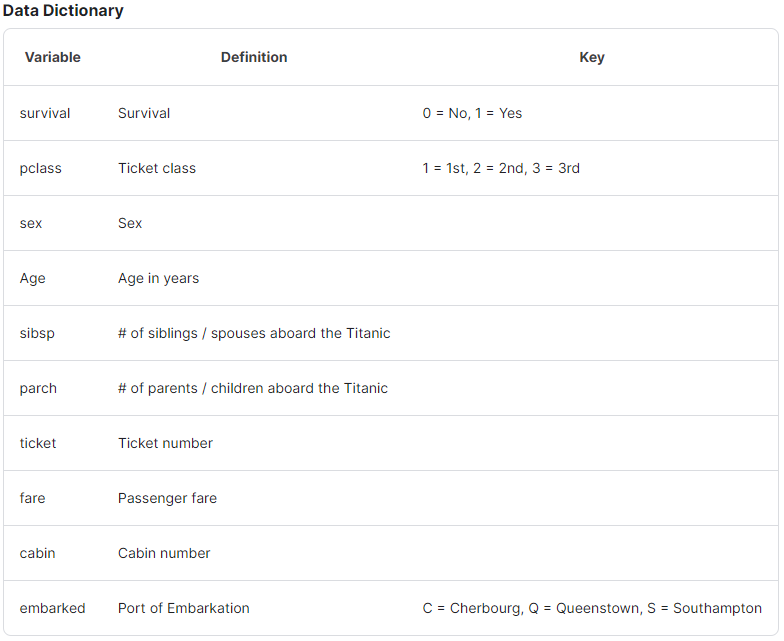

In [35]:
Image(filename="FeaturesDescriptions.png", width = 600)

So in summary, the training set has features as follows:<br>
<ul>
    <li>Five are text based and yield categorical or specific information about the passenger: Name, Sex, Ticket, Cabin, and Embarked.</li>
    <li>Two are numerical but are discrete and represent categories: Survived is binary, with 0 indicating the death of a passenger and 1 indicating survival. Pclass takes the values 1, 2, or 3, corresponding to the passenger's class aboard the ship.</li>
    <li>Four are numerical and quantitative: Age and Fare take continuous values greater than zero while Sibsp and Parch, both indicating the number of different types of relatives of the passenger aboard the ship, take integer values zero or larger.</li>
</ul>
Here it should be noted that a passenger's value for the Survived feature are labels! These values will train the Survival Prediction Model. <b>The training set will not have Survived values, thus while the training set has 11 features, the training set will only have ten.</b>

## A Quick Improvement: Making Sex Numerical

Since a passenger's sex is binary, the Sex feature can easily be made numerical, thereby making this feature cooperate better with quantitative models. Let's swap out values of "male" with 0 and values of "female" with 1.

In [36]:
df_train["Sex"] = df_train["Sex"].replace({"male":0,"female":1})
df_test["Sex"] = df_test["Sex"].replace({"male":0,"female":1})

## Diamond Data in the Rough: Utilizing the Name Feature

First names and surnames are unique to individuals, and therefore do not provide much useful predictive information on their own; however, Name values in this dataset are special: each carries an honorific title (ex. "Mr." or "Mrs.") for a passenger. An honorific title can convey a great deal of information about one's age and socioeconomic status, especially in the early 20th century. For instance, a title of "Mrs." likely indicates that the passenger was female and of marriage age. A title of "Rev.", short for Reverend, likely indicates that a passenger is male, middle-aged, and firmly within the middle class. A title of "Countess."? Perhaps royalty and someone who may have received special treatment aboard the Titanic.<br><br>

To extract the information encapsulated by one's honorific, we will add a new feature, NameTitle, to the dataset.

In [37]:
df_train["NameTitle"] = df_train["Name"].str.extract(r'\b(\w+)\.')
df_test["NameTitle"] = df_test["Name"].str.extract(r'\b(\w+)\.')

# Missing Values in the Training Set

So far, we have made two text-based features quantitative, thus increasing our ability to use numerical models on our datasets. Now it is time to start addressing the values that are missing in our datasets. Let's see which features are missing values and how many they are missing.

In [38]:
train_size, test_size = len(df_train), len(df_test)
print(f"The training set has {train_size} total entries.")
print()
print("Columns with missing values:")
for column in df_train.columns:
    null_values = df_train[column].isnull().sum()
    if null_values > 0:
        print(f"  · {column}:  {null_values} missing values.")

The training set has 891 total entries.

Columns with missing values:
  · Age:  177 missing values.
  · Cabin:  687 missing values.
  · Embarked:  2 missing values.


Looks like we have two features that are significantly lacking in data! It is common knowledge that age played an important role in survival of the Titanic disaster — and the training set is missing 19.9% of these values! Moreover, the cabin feature indicates where a passenger stayed aboard the ship, another crucial piece of information for this task and the training set is missing 77.1% of these values!<br><br>In order to make proper survival predictions, these missing values must be addressed, either by an estimation method or by making the best of the information we do have for these passengers. 

## Clean Records vs. Missing Records: Is the Completion of a Passenger's Information Correlated with Their Survival?

It would be reasonable to suppose that passengers with complete information (no missing feature values) had a higher survival rate than passengers with incomplete records. Among several reasons for making this assumption is simply <b>Survivorship Bias</b>. It is possible that passenger records were improved upon or made complete <i>after</i> the disaster especially given how momentous the event was. In this case, those who survived would have been able to provide information that was previously missing to those who held/collected passenger data. Those who perished would not have been able to provide their information. Whether or not survivorship bias is the root cause for our missing data, it is valuable nonetheless to check if there is a significant difference in survival rate between those with complete records and those without.<br><br>

To begin, we will add a feature to the training set called CompleteInfo, which is 1 for training set entries that have no null values, and 0 otherwise.

Number of training set entries containing no null values:
False    708
True     183
Name: CompleteInfo, dtype: int64

Average survival rate of those in training set having no null values (True) and those with null values (False).
CompleteInfo
False    0.309322
True     0.672131
Name: Survived, dtype: float64



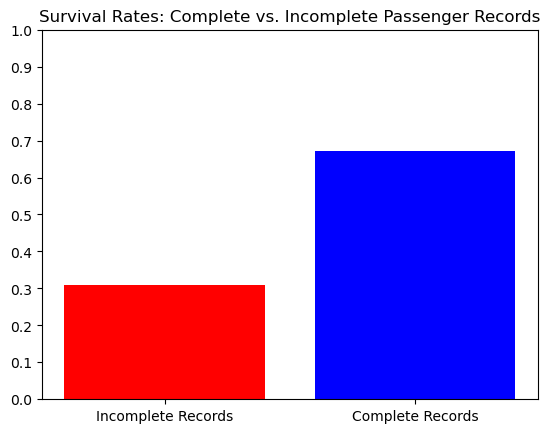

In [39]:
# Add a CompleteInfo Column to the DataFrames, with True if an entry has no null values, and False otherwise.
df_train["CompleteInfo"] = df_train.notnull().all(axis=1)

complete_info_count = df_train["CompleteInfo"].value_counts()
print("Number of training set entries containing no null values:")
print(complete_info_count)
print()

means = df_train.groupby('CompleteInfo')['Survived'].mean()
print("Average survival rate of those in training set having no null values (True) and those with null values (False).")
print(means)
print()

fig, ax = plt.subplots()
bar_colors = ['red', 'blue']
bar_labels = ['Incomplete Records', 'Complete Records']
ax.bar(bar_labels, means, color=bar_colors)
ax.set_ylim(0.0, 1.0)
ax.set_yticks([i/10 for i in range(11)])
ax.set_title('Survival Rates: Complete vs. Incomplete Passenger Records')
plt.show()

df_train["CompleteInfo"] = df_train["CompleteInfo"].replace({False:0,True:1})

This seems to be a very large difference in the survivorship of those with complete records compared to those without. Let's verify the statistical significance! Let $n_1$ be the number of passengers in the training set with no null values. Likewise, let $n_2$ be the number in the training set who are missing a value for at least one feature. Additionally, let $p_1$ be the proportion of those aboard with no missing feature values and let $p_2$ be the same proportion for those who are missing at least one feature value.<br><br>
$$n_1=183$$
$$n_2=708$$
$$p_1 \approx 67.21%$$
$$p_2 \approx 30.93%$$<br>
Let's check the statistical significance of the difference in survival rates, using a <i>95% confidence interval</i>. First we compute the standard error, $SE$.<br><br>
$$SE=\sqrt{\frac{p_1(1-p_1)}{n_1} + \frac{p_2(1-p_2)}{n_2}}=\sqrt{\frac{0.6721(1-0.6721)}{183}+\frac{0.3093(1-0.3093)}{708}} \approx 0.03881$$<br>
For a 95% confidence interval, the associated Z-score is approximately: $Z=1.96$, and thus the confidence interval $CI$ is:<br><br>
$$CI=(p_1-p_2) \mp Z \cdot SE=(0.6721-0.3093) \mp 1.96 \cdot 0.03881=[0.28673,0.43887]$$<br>
This means that in the full population, we can be 95% certain that the difference in survival rates between those with complete records and those without is between ~28.7% and ~43.9%. Even with a difference of 28.7% (the lower boundary) between the two cohorts, the difference in survival is massive. Thus, its important to keep an eye on the passengers with/without null values, and perhaps incorporate this information into the final prediction model.<br><br>

Moreover, given just how significant difference is, it is very reasonable to assume that this trend will persist in the test set, so we will keep the CompleteInfo feature in the training set and add it to the test set.

In [40]:
df_test["CompleteInfo"] = df_test.notnull().all(axis=1)
df_test["CompleteInfo"] = df_test["CompleteInfo"].replace({False:0,True:1})

## Estimating the Two Missing Embarked Values

### Mode: A Very Simple Estimation

Two out of 891 Embarked values are missing in the training set. Using a similar 95% confidence interval approach as above, we can get an estimate of the number of missing embarked values in the test set. Let $N$ be the size of the training set and $P$ be the proportion of missing values in $N$.<br><br>
$$N=891$$
$$P=\frac{2}{891} \approx 0.0024$$<br>
Using the same formula for standard error, we have:<br><br>
$$SE=\sqrt{\frac{P(1 - P)}{N}}=\sqrt{\frac{\frac{2}{891}(1-\frac{2}{891})}{891}} \approx 0.00159$$<br>
This gives a 95% confidence interval of:<br><br>
$$CI=P \mp Z \cdot SE=\frac{2}{891} \mp 1.96 \cdot 0.00159 \approx [-0.00086, 0.00535]$$
Let $N'$ denote the size of the test set.<br><br>
$$N'=418$$<br>
Multiplying the confidence interval by $N'$, and rounding the values to the nearest integer greater than or equal to zero gives:<br><br>
$$N' \cdot CI=418 \cdot [-0.00086, 0.00535] \approx [0, 2]$$<br>
This means that we can be 95% certain that the number of missing Embarked values in the test set is no greater than 2, less than 0.5% the size of the test set. With so few missing Embarked values, it is reasonable to assume that a highly sophisticated method for estimating the missing Embarked values will do little to improve the predictive power of the model, and moreover, introduces the risk of overfitting this parameter within the model. Therefore, for this feature, simplicity is key. We will assign the mode Embarked value of the dataset to the missing values.

In [41]:
mode_embarked = df_train["Embarked"].mode()[0]
df_train["Embarked"].fillna(mode_embarked, inplace=True)

mode_embarked = df_test["Embarked"].mode()[0]
df_test["Embarked"].fillna(mode_embarked, inplace=True)

## Estimating Missing Age Values

The training set is missing 177 values for the Age feature — that accounts for approximately 20% of the training set. Age values are quantitative, continuous, and critically important for the ultimate prediction task of this project. Therefore, we devise a way to make high-quality estimations to fill in our missing values. Let's take stock of what we know about Age values and what information we have readily available in our training set.<br><br>

First, we can recognize that predicting age values falls is a regression task. Since age values are continuous, the task of predicting them requires us to assemble a parametric model. So what can we use as parameters?<br><br>

In order to perform regression, the parameters we employ in our model must be numerical and quantitative, rather than categorical.<br>
<ul>
    <li>Let's start by looking at the Pclass parameter, which stradles this threshold. While its values indicate a given passenger's class, a category that the passenger belonged to, these values do have quantitative merit. First class, a Pclass value of 1, is in some real sense "above" classes two and three. These values can easily be interpreted as rankings.</li>
    <li>Next comes the Sex feature: Earlier, we replaced values of "male" with 0 and "female" with +1. Since Sex only takes binary values, we can definitely interpret it as numerical.</li>
    <li>SibSp and Parch are unequivocally numerical. Additionally, these features provide information about the family structure of a passenger; a key indicator of age.</li>
    <li>Fare is purely quantitative. A passenger's fare price is indicative of their socioeconomic status, and thereby accumulated wealth. Since wealth takes time to accumulate, it is quite reasonably to assume that it might be an indicator of one's age.</li>
    <li>Lastly, we have the albatross of our parameter set: NameTitle. Honorific titles are purely categorical; however, they reveal much about a passengers station in life. Perhaps we can apply a creative method to derive numerical data from NameTitle values.</li>
</ul>
And thus we have the parameter set with which we will attempt to estimate missing ages: Pclass, Sex, SibSp, Parch, Fare, and NameTitle. Since we are including NameTitle; however, we cannot yet proceed to selecting our regression model. We will first come up with a way to extract numbers out of names. 

### Two Approaches for Wrangling the NameTitle Feature

We will employ two seperate approaches for handling the categorical, text-based values in the NameTitle feature.<br>
<ol>
    <li>The first approach is the more straightforward one. We will simply encode the NameTitle value for each entry by adding a feature to our training set for each unique value contained in NameTitle. We can do this via dummy variables. If a passenger carries a NameTitle of "Mr.", for instance, his entry will have a 1 in the column corresponding to "Mr.", and a value of 0 in all other dummy variable columns. While very easy to implement, this approach does have drawbacks, the largest of which is that it will cause the dimensionality of our dataset to rapidly ballon to nearly three times its original size.</li>
    <li>The second approach is a bit more sophisticated, but will not alter the dimensionality of our data. We will use the Smoothed Target Encoding method to replace NameTitle values with an amalgum of average Age values. To explain this approach, we will introduce some notation. Each entry $x$ in our dataset belongs to some cohort, $c$ according to the entry's NameTitle value. For the sake of example, let's define cohort $c$ as the one that corresponds to having a NameTitle value of "Rev." We can compute the mean Age value of cohort $c$ by taking the mean of the ages of all members of the cohort. Let's denote this mean as $\mu_{c}$. We can also easily obtain the mean Age of the entire dataset. Let's call this term $\mu_{D}$. According to the size of cohort $c$ and according to a regularization hyperparameter that we are free to define as we would like, we can define two weights, $w_1$ and $w_2$. $w_1$ and $w_2$ are weight values, where $w_1 + w_2 = 1$. We can then compute a replacement value, $r$, for the NameTitle value of x as follows: $r=w_{1} \cdot \mu_{c} + w_{2} \cdot \mu_{D}$</li>
</ol><br>
We can run these two approaches in tandem and decide which type of encoding to use for predictions once we evaluate their respective performances in conjunction with the regression models that are compared. To get started in this process, we will first segment our training dataset into two smaller sets; the first containing only those entries of the training set with age values known from the beginning, and the second set containing only those entries of the dataset that are missing age values. Next, we will obtain dummy variable encodings to augment the training set and smoothed target encodings to replace NameTitle values. 

In [42]:
df_age_prediction = df_train[["Age", "Pclass", "Sex", "SibSp", "Parch", "Fare", "NameTitle"]].copy()

df_known_ages = df_age_prediction[df_age_prediction["Age"].notnull()].copy()
df_unknown_ages = df_age_prediction[df_age_prediction["Age"].isnull()].copy()
df_unknown_ages.drop("Age", axis = 1, inplace = True)

# Dummy variable encoding for both dataframes
df_known_ages_dummy = pd.get_dummies(df_known_ages, columns=["NameTitle"])
df_unknown_ages_dummy = pd.get_dummies(df_unknown_ages, columns=["NameTitle"])

# Smoothed Target Encoding
target_enc = TargetEncoder(smoothing=True)
df_known_ages["NameTitle"] = target_enc.fit_transform(df_known_ages["NameTitle"], df_known_ages["Age"])

#### Training Candidate Models

With numerical values now generated to stand in for categorical NameTitle values, we will now consider three candidate regression models to evaluate.<br><br>

<b>Option 1: Linear Regression</b><br>
In Linear Regression, we try to find a weight vector $w$ that optimally fits the examples $x^{(i)} \in \mathbb{R^D}$ in the training set $X$ to a linear model:
$$y=\displaystyle\sum_{j=0}^{D}x^{(i)}_{j} \cdot w_{j}$$
In this case, the number of examples $N$ within $X$ is far greater than the dimensionality $D$ of an example $x^{(i)}$, so the optimal vector $w$ must be found using gradient descent. This involves minimizing the squared difference between the model's predictions, $y$, and the true value $\hat{y^{(i)}}$ for every example in $X$. Finding the optimal values $w_j$ for each component of vector $w$ is done by iteratively updating each component after finding the derivative of the cost function $C(w)$ with respect to that component:
$$w_j \leftarrow w_j - \alpha \frac{\partial}{\partial w_j} C(w) \text{, where } \alpha \text{ is the learning rate}$$<br><br>

<b>Option 2: Decision Tree Regression</b><br>
Decision tree regression is another way to estimate continuous variables, like ages. Here's a brief summary of how it works:<br>
<ol>
    <li>A training example is sent to the root of the tree, and a binary question is asked, such as "Is this example's Pclass value equal to 1?".</li>
    <li>Based on the outcome, the example moves to the next branch of the tree where another binary question is asked of it, and so on.</li>
    <li>Once the example reaches the end of the tree, the predicted value is computed by taking the mean of the target values of the other members who reside on this final leaf.</li>
</ol>
Below is an example diagram for an example passenger with the following characteristics:<br>
<ul>
    <li>Has a Pclass value of 1</li>
    <li>Who is male</li>
    <li>Who has a SibSp value of 0</li>
    <li>Who has a Parch value of 0</li>
    <li>Whose fare was less than 50</li>
    <li>Who has a NameTitle of Mr.</li>
</ul>
There are 39 members of the training set who also have these characteristics, and their mean age is about 46, thus this example is predicted to have an age of about 46.

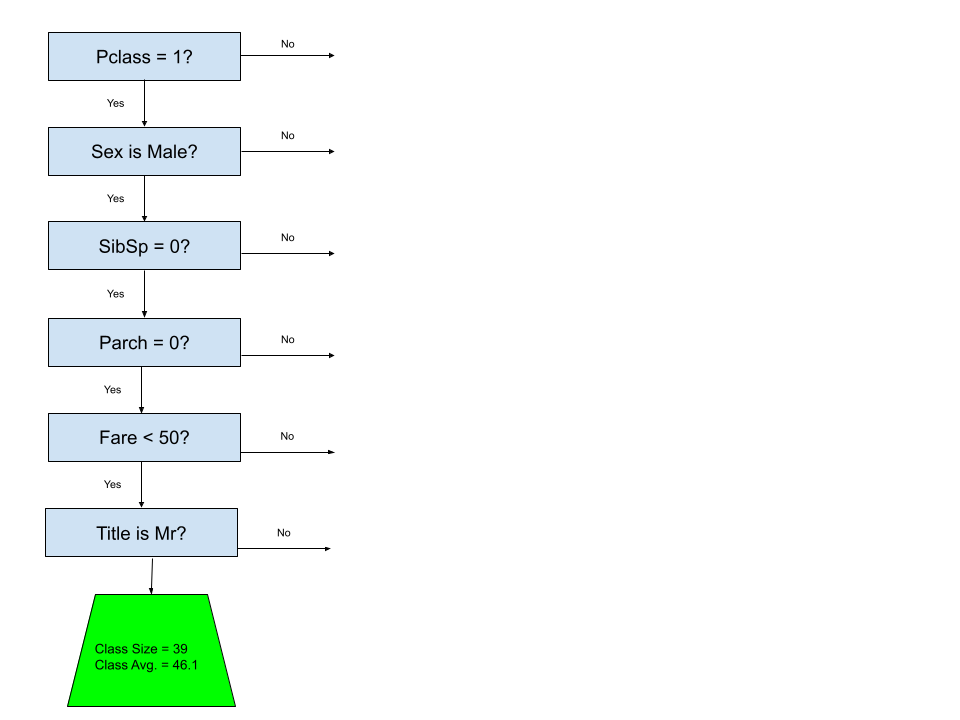

In [43]:
Image("DecisionTreeRegression.png", width = 650)

<b>Option 3: Random Forest Regression</b><br>
Finally, Random Forest Regression is quite similar to Decision Tree Regression; however, instead of a single decision tree, it uses several of them, each varying slightly from the others. The resulting prediction for an example is the mean of each tree's prediction. This model leverages randomness to mitigate the risk of overfitting commonly associated with decision tree regression.

### Tuning Hyperparameters for Six Candidate Model-Encoding Pairs

We have six model-encoding pairs that we will compare: two encoding approaches for each of the three models. Let's optimize the hyperparameters for each of these approaches using Scikit-Learn's Grid Search function. Though this can be a lengthy process, we can reduce the number of model-encoding searches from 6 to 4 as Linear Regression doesn't have meaningful hyperparameters to tune.

In [44]:
training_sets = [(df_known_ages_dummy.drop(columns="Age"), df_known_ages_dummy["Age"], "DmyVarEnc"),
                (df_known_ages.drop(columns=["Age"]), df_known_ages["Age"], "TgtEnc")]

models = [(LinearRegression(), "LinReg"), (DecisionTreeRegressor(), "DecTrReg"),
          (RandomForestRegressor(), "RdmFrstReg")]

trial_number = "[[FINAL]]"

all_param_grids = {
    "LinReg w/ DmyVarEnc" : {},
    "LinReg w/ TgtEnc" : {},
    "DecTrReg w/ DmyVarEnc" : {
        'max_depth': [7],
        'max_features': [0.5],
        'min_samples_leaf': [3],
        'min_samples_split': [6]
    },
    "RdmFrstReg w/ DmyVarEnc" : {
        'max_depth': [5],
        'max_features': [0.5],
        'min_samples_leaf': [1],
        'min_samples_split': [4],
        'n_estimators': [60]
    },
    "DecTrReg w/ TgtEnc" : {
        'max_depth': [3],
        'max_features': [5], 
        'min_samples_leaf': [1],
        'min_samples_split': [9]
    },
    "RdmFrstReg w/ TgtEnc" : {
        'max_depth': [5],
        'max_features': [3],
        'min_samples_leaf': [1],
        'min_samples_split': [2],
        'n_estimators': [75]
    }
}

model_enc_pairs = []

m_e_final_best_params = []

print(f"TRIAL {trial_number}")
print(("_"*60))
computation_time = 0 
for ts in training_sets:
    for m in models:
        model = m[0]
        X_train = ts[0]
        y_train = ts[1]
        m_name = m[1]
        m_e_name = m_name + " w/ " + ts[2]
        p_grid = all_param_grids[m_e_name]
        print(("_"*60))
        print(f"Finding best hyperparameters for {m_e_name}...")
        print(f"Testing over parameter space: {p_grid}...")
        if m_name != "LinReg":
            start = datetime.datetime.now()
            print(f"Search started at {start}")
            grid_search = GridSearchCV(estimator=model, param_grid=p_grid, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
            grid_search.fit(X_train, y_train)
            stop = datetime.datetime.now()
            print(f"Search ended at {stop}")
            m_e_computation_time = (stop - start).total_seconds()
            computation_time += m_e_computation_time
            print(f"Hyperparameter tuning for {m_e_name} took {round(m_e_computation_time,3)} seconds.")
            best_params = grid_search.best_params_
            print()
            print(f"* Best Parameters for {m_e_name}...")
            print("    * " + f"{best_params}")
        else:
            print(f"Hyperparameter tuning skipped for {m_e_name}.")
            best_params = {"LINEAR REGRESSION HAS NO HYPERPARAMETERS" : "NO HYPERPARAMETERS"}
        if trial_number == "[[FINAL]]":
            m_e_final_best_params.append((m_e_name, best_params))
        model_enc_pairs.append((model, X_train, y_train, p_grid, best_params, m_name, m_e_name))
print("_"*60)
print(f"Total Computation time for TRIAL #{trial_number}: {round(computation_time,3)} seconds.")
print(("_"*60))
print(("_"*60))
print(("_"*60))
for ap in list(all_param_grids.items()):
    print("* " + ap[0])
    for pg in list(ap[1].items()):
        print(f"  * {pg[0]} --> {pg[1]}")
    print()

# Change show_trial_log to True to show a log of each hyperparameter tuning trial
show_trial_log = False
if show_trial_log:
    with open("Age_Hyperparameter_Tuning_Log.txt", "r") as f:
        trial_log = f.read()
    print(trial_log)

TRIAL [[FINAL]]
____________________________________________________________
____________________________________________________________
Finding best hyperparameters for LinReg w/ DmyVarEnc...
Testing over parameter space: {}...
Hyperparameter tuning skipped for LinReg w/ DmyVarEnc.
____________________________________________________________
Finding best hyperparameters for DecTrReg w/ DmyVarEnc...
Testing over parameter space: {'max_depth': [7], 'max_features': [0.5], 'min_samples_leaf': [3], 'min_samples_split': [6]}...
Search started at 2023-06-13 02:13:44.728620
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Search ended at 2023-06-13 02:13:50.235744
Hyperparameter tuning for DecTrReg w/ DmyVarEnc took 5.507 seconds.

* Best Parameters for DecTrReg w/ DmyVarEnc...
    * {'max_depth': 7, 'max_features': 0.5, 'min_samples_leaf': 3, 'min_samples_split': 6}
____________________________________________________________
Finding best hyperparameters for RdmFrstReg w/ DmyVarEn

In [45]:
opt_models_enc = {
    'LinReg w/ DmyVarEnc' : {
        "model_type" : LinearRegression(),
        "X_train" : df_known_ages_dummy.drop(columns="Age"),
        "y_train" : df_known_ages_dummy["Age"]
    },
    
    'DecTrReg w/ DmyVarEnc' : {
        "model_type" : DecisionTreeRegressor(
            max_depth = 7,
            max_features = 0.5,
            min_samples_leaf = 3,
            min_samples_split = 6
        ),
        "X_train" : df_known_ages_dummy.drop(columns="Age"),
        "y_train" : df_known_ages_dummy["Age"]
    },
    
    'RdmFrstReg w/ DmyVarEnc' : {
        "model_type" : RandomForestRegressor(
            max_depth = 5,
            max_features = 0.5,
            min_samples_leaf = 1,
            min_samples_split = 4,
            n_estimators = 60
        ),
        "X_train" : df_known_ages_dummy.drop(columns="Age"),
        "y_train" : df_known_ages_dummy["Age"]
    },
    
    'LinReg w/ TgtEnc' : {
        "model_type" : LinearRegression(),
        "X_train" : df_known_ages.drop(columns=["Age"]),
        "y_train" : df_known_ages["Age"]
    },
    
    'DecTrReg w/ TgtEnc' : {
        "model_type" : DecisionTreeRegressor(
            max_depth = 3,
            max_features = 5,
            min_samples_leaf = 1,
            min_samples_split = 9
        ),
        "X_train" : df_known_ages.drop(columns=["Age"]),
        "y_train" : df_known_ages["Age"]
    },
    
    'RdmFrstReg w/ TgtEnc' : {
        "model_type" : RandomForestRegressor(
            max_depth = 5,
            max_features = 3,
            min_samples_leaf = 1,
            min_samples_split = 2,
            n_estimators = 75
        ),
        "X_train" : df_known_ages.drop(columns=["Age"]),
        "y_train" : df_known_ages["Age"]
    }
}

#### Identifying Top-Performing Model-Encoding Pair

With two approaches to encoding NameTitle values and three candidate regression models, there will be six total model-encoding pairs to evaluate. We will then conduct a learning curve analysis with cross-validation to assess the performance of each pair and select the top-performing model-encoding pair to predict the missing age values in our datasets. The selection criteria for the top performing model are as follows:<br>
<ol>
    <li><b>Low MSE Test Score:</b> A low MSE test score indicates strong performance in cross-validation. This means that the model-encoding pair generalizes its performance well on new data. (Note that a low score in this context refers to a score that is close to zero. Though scores are negative, we are looking for models that have scores with the smallest absolute value.)</li>
    <li><b>Convergence between training performance and cross-validation performance:</b> We are looking for models that have training scores and test scores that trend towards convergence as training set size increases. A trend toward convergence indicates that the model is less prone to overfitting and that a good balance between learning and regularization is established.</li>
    <li><b>Smoothness of score trends:</b> While, in general, convergence between training scores and test scores is good, trend lines that seem to nearly crash into one another and then recoil is a red flag. Turbulent score trends indicate that a model is overly sensitive to the number of training examples.</li>
</ol>

Let's take a look at how each model-encoding pair performed! Here are six plots displaying how each pair performed in training and cross-validation as the number of training examples increased.

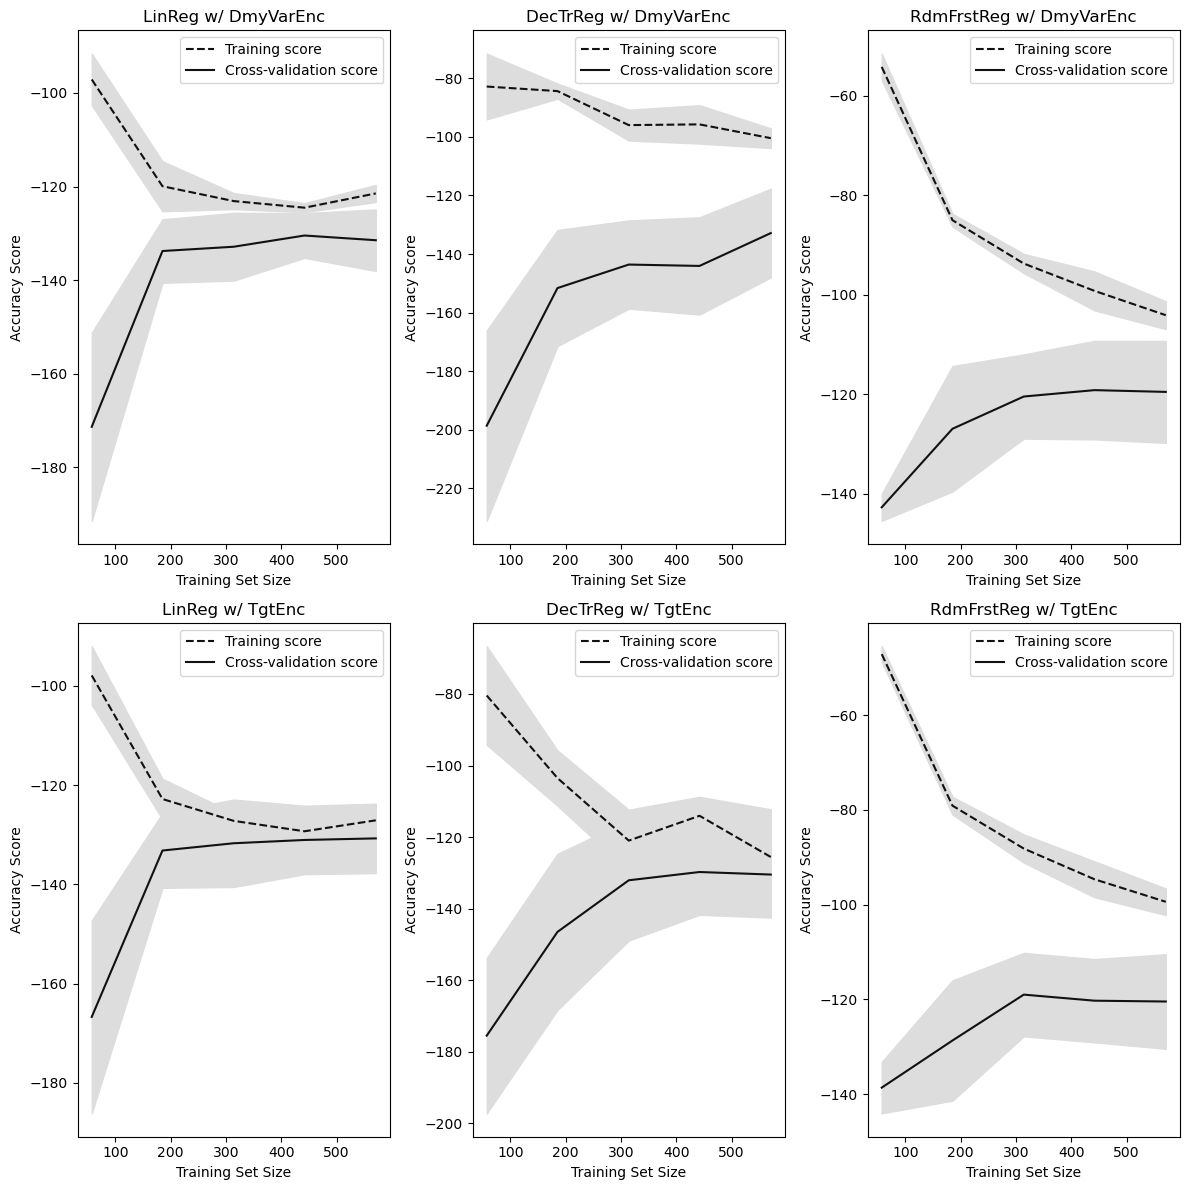

In [46]:
def get_learning_curve_analysis_outputs(model, X, y, cv = 5, full_name = None):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(.1, 1.0, 5))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    if full_name is not None:
        return (train_sizes, train_scores, test_scores, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std, full_name)
    else:
        return (train_sizes, train_scores, test_scores, train_scores_mean, train_scores_std, test_scores_mean, test_scores_std)

candidate_models = list(opt_models_enc.keys())
all_lc_scores = []
for cm in candidate_models:
    model = opt_models_enc[cm]
    model_type = model["model_type"]
    X_train = model["X_train"]
    y_train = model["y_train"]
    lc_scores = get_learning_curve_analysis_outputs(model_type, X_train, y_train, full_name = cm)
    all_lc_scores.append(lc_scores)

lc_idx = 0
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))
for i in range(num_rows):
    for j in range(num_cols):
        axes[i][j].plot(all_lc_scores[lc_idx][0], all_lc_scores[lc_idx][3], '--', color="#111111",  label="Training score")
        axes[i][j].plot(all_lc_scores[lc_idx][0], all_lc_scores[lc_idx][5], color="#111111", label="Cross-validation score")
        axes[i][j].fill_between(all_lc_scores[lc_idx][0], all_lc_scores[lc_idx][3] - all_lc_scores[lc_idx][4], all_lc_scores[lc_idx][3] + all_lc_scores[lc_idx][4], color="#DDDDDD")
        axes[i][j].fill_between(all_lc_scores[lc_idx][0], all_lc_scores[lc_idx][5] - all_lc_scores[lc_idx][6], all_lc_scores[lc_idx][5] + all_lc_scores[lc_idx][6], color="#DDDDDD")
        axes[i][j].set_title(f"{all_lc_scores[lc_idx][7]}")
        axes[i][j].set_xlabel("Training Set Size"), axes[i][j].set_ylabel("Accuracy Score"), axes[i][j].legend(loc="best")
        lc_idx += 1
plt.tight_layout()
plt.show()

Now, let's go through the results:
<ol>
    <li><b>Linear Regression w/ Dummy Variable Encoding:</b> The model appears to slightly overfit, as the training error is smaller than the testing error. However, the discrepancy isn't very large, which is a good sign. The training and testing error don't change drastically with increasing train size, indicating reasonable model stability.</li>
    <li><b>Decision Tree Regression w/ Dummy Variable Encoding:</b> This model also overfits, with a more considerable gap between training and testing error, especially with smaller training sizes. The model seems to stabilize with a larger dataset, suggesting that increasing the train size might improve performance.</li>
    <li><b>Random Forest Regression w/ Dummy Variable Encoding:</b> This model seems to perform the best in terms of balancing bias and variance. The training and testing errors are close together and relatively low, indicating a good fit without much overfitting.</li>
    <li><b>Linear Regression w/ Target Encoding:</b> This model also overfits slightly but not as much as the Decision Tree. However, it has a higher overall error rate compared to the Random Forest model, especially in the test scores.</li>
    <li><b>Decision Tree Regression w/ Target Encoding:</b> This model seems to overfit quite significantly, especially with smaller training sizes. The model does better with larger training sizes, but still not as well as the Random Forest.</li>
    <li><b>Random Forest Regression w/ Target Encoding:</b> This model performs similarly to the Random Forest with Dummy Variable Encoding. The training and testing errors are close together and relatively low, indicating a good fit without much overfitting.</li>
</ol>
Based on these observations, it seems like both Random Forest models are the best performing in terms of prediction quality and controlling overfitting. Of the two, the <b>Random Forest Regression with Target Encoding</b> appears to have the smallest average testing error, suggesting that it's likely the best performing model of the six.<br><br>

Thus we have dialed in on a model and encoding strategy that yields high quality Age predictions. Let's use the model to predict our missing age values and move on to the next data cleaning task.

In [47]:
# Transform NameTitle values in df_unknown_ages using the target encoder
df_unknown_ages["NameTitle"] = target_enc.transform(df_unknown_ages["NameTitle"])

# Make RFR training set from df_known_ages
X_train, y_train = df_known_ages.drop(columns=["Age"]), df_known_ages["Age"]

# Initialize Random Forest Regressor and fit it to X_train and y_train
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)

# Make Age predictions for df_unknown_ages and pdate df_train with the age predictions
age_predictions = RFR.predict(df_unknown_ages)
df_train.loc[df_unknown_ages.index, "Age"] = age_predictions

# Getting age predictions for the test set
df_age_prediction_test = df_test[["Age", "Pclass", "Sex", "SibSp", "Parch", "Fare", "NameTitle"]].copy()
# Addressing any missing values that are contained in the Pclass, Sex, SibSp, Parch, or Fare columns
df_age_prediction_test['Pclass'].fillna(round(df_age_prediction_test['Pclass'].mean()), inplace=True)
df_age_prediction_test['Sex'].fillna(df_age_prediction_test['Sex'].mode()[0], inplace=True)
df_age_prediction_test['SibSp'].fillna(round(df_age_prediction_test['SibSp'].mean()), inplace=True)
df_age_prediction_test['Parch'].fillna(round(df_age_prediction_test['Parch'].mean()), inplace=True)
df_age_prediction_test['Fare'].fillna(df_age_prediction_test['Fare'].mean(), inplace=True)
# Discard entries of df_age_prediction_test with known age values. The age prediction models are already
    # trained, so entries with known age values become irrelevant after addressing potential null values in
    # the step above. 
df_age_prediction_test = df_age_prediction_test[df_age_prediction_test["Age"].isnull()]
# Transform NameTitle values using the target encoder
df_age_prediction_test["NameTitle"] = target_enc.transform(df_age_prediction_test["NameTitle"])
# Drop the Age column to prepare for predictions via the trained Random Forest Regression model
df_age_prediction_test.drop("Age", axis = 1, inplace = True)
# Use the trained Random Forest Regressor to get Age predictions
age_predictions_test = RFR.predict(df_age_prediction_test)
# Update df_test with the predicted age values
df_test.loc[df_age_prediction_test.index, "Age"] = age_predictions_test

## Wrangling Cabin Feature Values

The last feature of the training set which has null values which need our attention is indeed the strangest. Let's take a look at the Cabin feature and see what we can make of it.

In [48]:
print(f"The Cabin column is missing {df_train['Cabin'].isnull().sum()} out of {len(df_train)} values," + 
      f"Thus we are missing approximately {round(100 * (df_train['Cabin'].isnull().sum()/len(df_train)),1)}% of this feature's data.")
print()
print("Let's take a look at what Cabin values look like among entries who have them...")
cabin_value_samples = list(df_train[df_train["Cabin"].notnull()]["Cabin"].values)
print(cabin_value_samples[:32])

The Cabin column is missing 687 out of 891 values,Thus we are missing approximately 77.1% of this feature's data.

Let's take a look at what Cabin values look like among entries who have them...
['C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33', 'F G73', 'C23 C25 C27', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101', 'D26', 'F E69', 'D47', 'C123', 'B86', 'F2', 'C2', 'E33']


Among the entries of the training set which do contain Cabin values, we find that these values generally follow an alphanumeric pattern, consisting of an uppercase letter followed by a number. Unfortunately, this naming convention is only followed loosely. We see some cabin values containing multiple alphanumeric codes, such as passenger 28's cabin value of "C23 C25 C27". Other Cabin values are even stranger, such as passenger 76's value of "F G73", or passenger 293's value, which is simply "D".<br><br>
Let's take a closer look at the "strange" cabin values that are not simple alphanumerics. These values can easily be identified, as they are either one character long, or possess one or more empty spaces, unlike normal alphanumerics.

In [49]:
one_char_cabin_values = list(set([i for i in cabin_value_samples if len(i) == 1]))
print("The one-character long Cabin values are...")
print(one_char_cabin_values)
print()
overpacked_cabin_values = list(set([i for i in cabin_value_samples if " " in i]))
print("The overpacked Cabin values are...")
print(overpacked_cabin_values)

The one-character long Cabin values are...
['T', 'D']

The overpacked Cabin values are...
['B82 B84', 'C23 C25 C27', 'D10 D12', 'C22 C26', 'F G63', 'C62 C64', 'F G73', 'B96 B98', 'F E69', 'B57 B59 B63 B66', 'B58 B60', 'B51 B53 B55']


Interestly, the one-character-long Cabin values are only "D" or "T". Even more interestingly, all Cabin values that consist of multiple alphanumerics have numbers that increase in very small increments, and often, by increments of two. I think we've all seen this pattern before...at adjacent rooms at hotels! It is very likely that Cabin values consisting of multiple alphanumerics indicate that a passenger had multiple side-by-side rooms booked for their voyage.<br><br>

This assumption affords us an opportunity to demystify Cabin values, albeit slightly. We can add two new features to our datasets: CabinLetter and CabinNumber. We can split the alphanumerics into their constiuent components, letters and numbers. In the case of a Cabin value having multiple numbers, we can simply take the average value of these room numbers. For one-character-long Cabin values, we will set the CabinNumber to "UNSPECIFIED". For Cabin values that include different letters, we will set CabinLetter values to both letters. Furthermore, in light of these small findings about Cabin values, a picture is starting to emerge. The letters likely represent different decks of the Titanic. We can see that for Cabin values with multiple letters, the letters are always consecutive. F immediately preceds G in the alphabet, and immediately follows E. Perhaps these Cabin values indicate rooms on mezzanines or other split-level areas on the ship?<br><br>

Let's now update our datasets as specified and continue sifting through this feature.

In [50]:
def process_cabin(row):
    cabin = row['Cabin']
    # Case: Cabin is null
    if pd.isnull(cabin):
        row['CabinLetter'] = None
        row['CabinNumber'] = None
    else:
        if cabin.isalpha() and len(cabin) == 1:
            row['CabinLetter'] = cabin
            row['CabinNumber'] = None
        else:
            cabins = cabin.split(' ')
            letters = [cabin[0] for cabin in cabins]
            if len(cabins) == 1:
                row['CabinLetter'] = letters[0]
                row['CabinNumber'] = re.findall(r'\d+', cabins[0])[0] if re.findall(r'\d+', cabins[0]) else None
            else:
                if len(set(letters)) == 1:
                    row['CabinLetter'] = letters[0]
                    numbers = [int(re.findall(r'\d+', cabin)[0]) for cabin in cabins if re.findall(r'\d+', cabin)]
                    row['CabinNumber'] = round(sum(numbers) / len(numbers)) if numbers else None
                else:
                    row['CabinLetter'] = ''.join(set(letters))
                    row['CabinNumber'] = re.findall(r'\d+', ''.join(cabins))[0] if re.findall(r'\d+', ''.join(cabins)) else None
    return row

df_train["CabinLetter"] = np.nan
df_train["CabinNumber"] = np.nan
df_train = df_train.apply(process_cabin, axis=1)

df_test["CabinLetter"] = np.newaxis
df_test["CabinNumber"] = np.newaxis
df_test = df_test.apply(process_cabin, axis=1)

cl_unique_values = df_train['CabinLetter'].unique().tolist()
cn_unique_values = df_train['CabinNumber'].unique().tolist()

### Exploring the CabinLetter and CabinNumber Features

Let's now look at the of the survival rates for the various CabinLetter and CabinNumber values.

In [51]:
cabin_letter_stats = df_train.groupby("CabinLetter").agg({"Survived":["count", "mean"],
                                                          "Pclass" : "mean",
                                                          "Age" : "mean",
                                                          "SibSp" : "mean",
                                                          "Parch" : "mean",
                                                          "Fare" : "mean"
                                                         })
cabin_letter_stats.columns = ['_'.join(col) for col in cabin_letter_stats.columns]
cabin_letter_stats.columns = ["Count","Mean Survived","Mean Pclass", "Mean Age", "Mean SibSp",
                              "Mean Parch", "Mean Fare"]
cabin_letter_stats

,Count,Mean Survived,Mean Pclass,Mean Age,Mean SibSp,Mean Parch,Mean Fare
CabinLetter,,,,,,,
A,15,0.466667,1.000000,46.606248,0.133333,0.133333,39.623887
B,47,0.744681,1.000000,34.794866,0.361702,0.574468,113.505764
C,59,0.593220,1.000000,37.042947,0.644068,0.474576,100.151341
D,33,0.757576,1.121212,39.372210,0.424242,0.303030,57.244576
E,32,0.750000,1.312500,37.920672,0.312500,0.312500,46.026694
F,9,0.777778,2.111111,19.464813,0.666667,0.666667,21.972222
FE,1,1.000000,3.000000,4.489298,1.000000,1.000000,22.358300
FG,3,0.000000,3.000000,28.666667,0.000000,0.000000,7.650000
G,4,0.500000,3.000000,14.750000,0.500000,1.250000,13.581250


Here are three noteworthy highlights from the above table:<br>
<ol>
    <li><b>Some decks only carry one passenger class.</b> We can see that decks A, B, C, and T only carry passengers in first class. Decks EF (formerly FE), FG, and G only carry passengers in third class.</li>
    <li><b>Small head counts for CabinLetter values.</b> We see that due to sparse data in the training set, only the decks of B, C, D, and E have large enough headcounts to be considered statistically significant. If we try to estimate the missing CabinLetter values, we will have to use these CabinLetter values as cohorts, and assign CabinLetter_Cohort values according to how well entries compare to these base CabinLetter_Cohort classes.</li>
    <li><b>Survival rate differences may or may not be statistically significant.</b> If we perform a Chi-Squared significance test on the survival rates for decks B, C, D, and E, the base CabinLetter_Cohort classes, we get a p-value of about 0.22, indicating that CabinLetters are insignificant predictors of survival; however, if we extrapolate these survival rates across the entire training set, with each cohort containing the same proportion of total membership as indicated in the table, we arrive at a p-value of far below 0.001. In order to evaluate significance, we would first need to predict the CabinLetter_Cohort for each missing value. We will return to this prediction task shortly.</li>
</ol>
Trying to predict CabinLetter_Cohort values for entries of the data with missing CabinLetter values is a frought process that invites the risk of overfitting. We will need to ensure that our predictions improve the predictive power of our dataset before modifying our data with predictions. Thus, we will approach this task using several models and use the top-performer to make our predictions.<br><br>

First, let's make note of the CabinLetter values within our data whose "headcounts" are statistically significant. The CabinLetter values B, C, D, and E have counts of 47, 59, 33, and 32, respectively. Though these counts are rather small, they are large enough to have statistical significance. Thus, we can use these CabinLetter values to form the base classes of the CabinLetter_Cohort feature. Let's take a closer look at these classes and add the CabinLetter_Cohort feature to our data.

In [52]:
cabin_letter_cohort_stats = cabin_letter_stats.loc[["B", "C", "D", "E"]]
cabin_letter_cohort_stats

,Count,Mean Survived,Mean Pclass,Mean Age,Mean SibSp,Mean Parch,Mean Fare
CabinLetter,,,,,,,
B,47,0.744681,1.000000,34.794866,0.361702,0.574468,113.505764
C,59,0.593220,1.000000,37.042947,0.644068,0.474576,100.151341
D,33,0.757576,1.121212,39.372210,0.424242,0.303030,57.244576
E,32,0.750000,1.312500,37.920672,0.312500,0.312500,46.026694


In [53]:
cohort_mapping = {'B': '1', 'C': '2', 'D': '3', 'E': '4'}

df_train['CabinLetter_Cohort'] = df_train['CabinLetter'].map(cohort_mapping)
df_train.loc[~df_train['CabinLetter'].isin(['B', 'C', 'D', 'E']), 'CabinLetter_Cohort'] = None

df_test['CabinLetter_Cohort'] = df_test['CabinLetter'].map(cohort_mapping)
df_test.loc[~df_test['CabinLetter'].isin(['B', 'C', 'D', 'E']), 'CabinLetter_Cohort'] = None

### Predicting Missing CabinLetter_Cohort Values

#### Four Candidate Classification Models

Since the CabinLetter_Cohort feature is categorical, coming up with predictions for missing values is a classification task. We have four candidate models for this task. They are as follows:
<ol>
    <li><b>Gradient Boosting Classifier:</b> An ensemble model of decision tree classifiers. Iteratively, it applies a decision tree classifier to the dataset, and computes the residual values (alternatively, negative gradients with respect to its loss function) between its predictions and the target values. Then a new model is fit to the residuals, where it aims to predict the error of the previous model. The overall predictions are then updated accordingly. After a number of iterations through this process, a final classification model is created from a weighted sum of the intermittent models.</li>
    <li><b>Decision Tree Classifier:</b> A simplified version of the above approach. This classifier operates in a similar fashion to the Decision Tree Regressor employed earlier in this project.</li>
    <li><b>Random Forest Classifier:</b> An ensemble of Decision Tree Classifiers initialized with random ordering of branches. It functions in a very similar manner to the Random Forest Regressor employed earlier.</li>
    <li><b>Ensemble Classifier (with soft voting):</b> This classifier is a combination of the three previous models. It trains each of them, and then combines the probabilities that each predicts into a weighted sum of probabilities for each class.</li>
</ol>
Unfortunately, the log of hyperparameter tuning trials was lost, but the optimized values remain in the code below.<br><br>

Since training data is especially scarce for this task, we will use K-Fold Cross-Validation to evaluate our models. This method splits data into training sets and validation sets multiple times, such that all partitions of the data serve as a validation set for a single pass. Means of specified performance scores are then computed. In this task, we will focus on four performance scores to assess the candidate models' predictive capacities:
<ol>
    <li><b>Accuracy:</b> Simply the number of correct predictions divided by the total number of predictions made.</li>
    <li><b>Precision:</b> The number of correct predictions for a given class divided by the total number of predictions for that class. In short, a metric to measure the rate of false positives.</li>
    <li><b>Recall:</b> The number of correct predictions for a given class divided by the actual number belonging to that class. In short, a metric to measure the rate of false negatives.</li>
    <li><b>F1:</b> The harmonic mean of Precision and Recall. A balancing score that takes both the false positive and false negative rates into account.</li>
</ol>
To assess our models' tendancies to overfit the scarce training data, we will also acquire the variances for each of these scores across each of the K folds. Low variances indicate that a given model is capable of generalizing its learning. The model that performs best overall between its performance scores and their variances will be considered the top-performer and will be used to predict missing CabinLetter_Cohort values.

Scores for Gradient Boosting Classifier:
    * Mean Accuracy: 0.59635; Accuracy Variance: 0.0021
    * Mean F1 Score: 0.59228; F1 Score Variance: 0.00359
    * Mean Precision: 0.64132; Precision Variance: 0.00411
    * Mean Recall: 0.59635; Recall Variance: 0.0021
    * Overall performance score (higher is better): 2.42629
    * Overall overfitting score (lower is better): 0.0119

Scores for Decision Tree Classifier:
    * Mean Accuracy: 0.56049; Accuracy Variance: 0.00872
    * Mean F1 Score: 0.55531; F1 Score Variance: 0.00991
    * Mean Precision: 0.57944; Precision Variance: 0.00839
    * Mean Recall: 0.56049; Recall Variance: 0.00872
    * Overall performance score (higher is better): 2.25574
    * Overall overfitting score (lower is better): 0.03574

Scores for Random Forest Classifier:
    * Mean Accuracy: 0.52644; Accuracy Variance: 0.00132
    * Mean F1 Score: 0.52035; F1 Score Variance: 0.00241
    * Mean Precision: 0.56237; Precision Variance: 0.00659
    * Mean Recall: 0.52

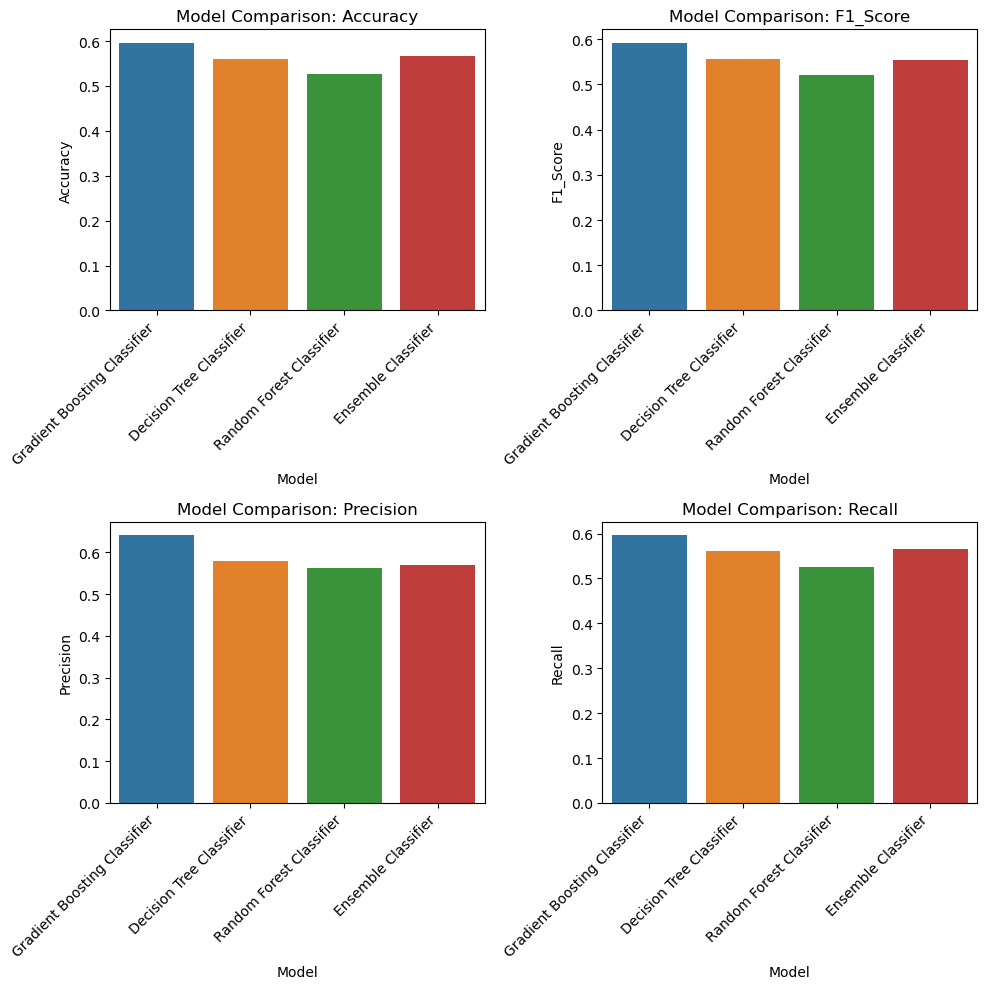

In [54]:
def perform_kfold_cv(classifier, df, features, target, k=4):
    kf = KFold(n_splits=k)
    accuracy_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    for train_index, test_index in kf.split(df):
        X_train, X_test = df.iloc[train_index][features], df.iloc[test_index][features]
        y_train, y_test = df.iloc[train_index][target], df.iloc[test_index][target]
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        accuracy_score_val = accuracy_score(y_test, y_pred)
        f1_score_val = f1_score(y_test, y_pred, average='weighted')
        precision_score_val = precision_score(y_test, y_pred, average='weighted')
        recall_score_val = recall_score(y_test, y_pred, average='weighted')
        accuracy_scores.append(accuracy_score_val)
        f1_scores.append(f1_score_val)
        precision_scores.append(precision_score_val)
        recall_scores.append(recall_score_val)
    return np.mean(accuracy_scores), np.mean(f1_scores), np.mean(precision_scores), np.mean(recall_scores), accuracy_scores, f1_scores, precision_scores, recall_scores

def visualize_model_performance(models_performance):
    metrics = ['Accuracy', 'F1_Score', 'Precision', 'Recall']
    fig, axs = plt.subplots(2, 2, figsize=(10,10))

    for i, metric in enumerate(metrics):
        ax = axs[i//2, i%2]
        sns.barplot(x='Model', y=metric, data=models_performance, ax=ax)
        ax.set_title(f'Model Comparison: {metric}')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    plt.tight_layout()
    plt.show()

# Create a training set to train the classification models
df_train_predict_cabin_letter_cohort = df_train[df_train["CabinLetter_Cohort"].notnull()].copy()

# Define feature columns
features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
target = 'CabinLetter_Cohort'

gbc = GradientBoostingClassifier(random_state=0,
                                 n_estimators = 300,
                                 learning_rate = 0.01,
                                 max_depth = 6,
                                 min_samples_split = 18)
dt = DecisionTreeClassifier(max_depth = 8,
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = None)
rf = RandomForestClassifier(random_state = 0,
                            n_estimators = 100,
                            max_depth = 6,
                            min_samples_split = 2,
                            min_samples_leaf = 1,
                            max_features = None)
eclf = VotingClassifier(estimators=[
    ("gbc", gbc),
    ('dt', dt), 
    ('rf', rf)
], voting='soft')

models_performance = pd.DataFrame()

classifiers = [(gbc,"Gradient Boosting Classifier"),(dt,"Decision Tree Classifier"),
               (rf,"Random Forest Classifier"),(eclf,"Ensemble Classifier")]
for classifier in classifiers:
    clsfr = classifier[0]
    c_name = classifier[1]
    mean_accuracy, mean_f1_score, mean_precision, mean_recall, accuracy_scores, f1_scores, precision_scores, recall_scores = perform_kfold_cv(clsfr, df_train_predict_cabin_letter_cohort, features, target)
    new_row = pd.DataFrame({'Model': [c_name], 'Accuracy': [mean_accuracy], 'F1_Score': [mean_f1_score], 'Precision': [mean_precision], 'Recall': [mean_recall]})
    models_performance = pd.concat([models_performance, new_row], ignore_index=True)
    print(f"Scores for {c_name}:")
    r5 = lambda x: round(x, 5)
    print(f"    * Mean Accuracy: {r5(mean_accuracy)}; Accuracy Variance: {r5(np.var(accuracy_scores))}")
    print(f"    * Mean F1 Score: {r5(mean_f1_score)}; F1 Score Variance: {r5(np.var(f1_scores))}")
    print(f"    * Mean Precision: {r5(mean_precision)}; Precision Variance: {r5(np.var(precision_scores))}")
    print(f"    * Mean Recall: {r5(mean_recall)}; Recall Variance: {r5(np.var(recall_scores))}")
    performance_score = mean_accuracy + mean_f1_score + mean_precision + mean_recall
    print(f"    * Overall performance score (higher is better): {r5(performance_score)}")
    overfitting_score = np.var(accuracy_scores) + np.var(f1_scores) + np.var(precision_scores) + np.var(recall_scores)
    print(f"    * Overall overfitting score (lower is better): {r5(overfitting_score)}")
    print()

visualize_model_performance(models_performance)

#### Classification with the Gradient Boosting Classifier

The Gradient Boosting Classifier was the top performing model over each performance score and came in a very close second among their variances. Accordingly, this model will be used to make CabinLetter_Cohort classifications for entries that are missing these values.

In [55]:
df_train_known_clc = df_train[df_train["CabinLetter_Cohort"].notnull()].copy()
df_train_unknown_clc = df_train[df_train["CabinLetter_Cohort"].isnull()].copy()

X_train = df_train_known_clc[features]
y_train = df_train_known_clc["CabinLetter_Cohort"]
gbc.fit(X_train, y_train)

X_test = df_train_unknown_clc[features]
predictions = gbc.predict(X_test)

df_train.loc[df_train_unknown_clc.index, "CabinLetter_Cohort"] = predictions

df_test_unknown_clc = df_test[df_test["CabinLetter_Cohort"].isnull()].copy()
df_test_unknown_clc["Pclass"].fillna(round(df_test["Pclass"].mean()), inplace = True)
df_test_unknown_clc["SibSp"].fillna(round(df_test["SibSp"].mean()), inplace = True)
df_test_unknown_clc["Parch"].fillna(round(df_test["Parch"].mean()), inplace = True)
df_test_unknown_clc["Fare"].fillna(df_test["Fare"].mean(), inplace = True)

X_test_test = df_test_unknown_clc[features]
predictions = gbc.predict(X_test_test)

df_test.loc[df_test_unknown_clc.index, "CabinLetter_Cohort"] = predictions

### Analysis of CabinNumber Values

#### Survival Rate by CabinNumber

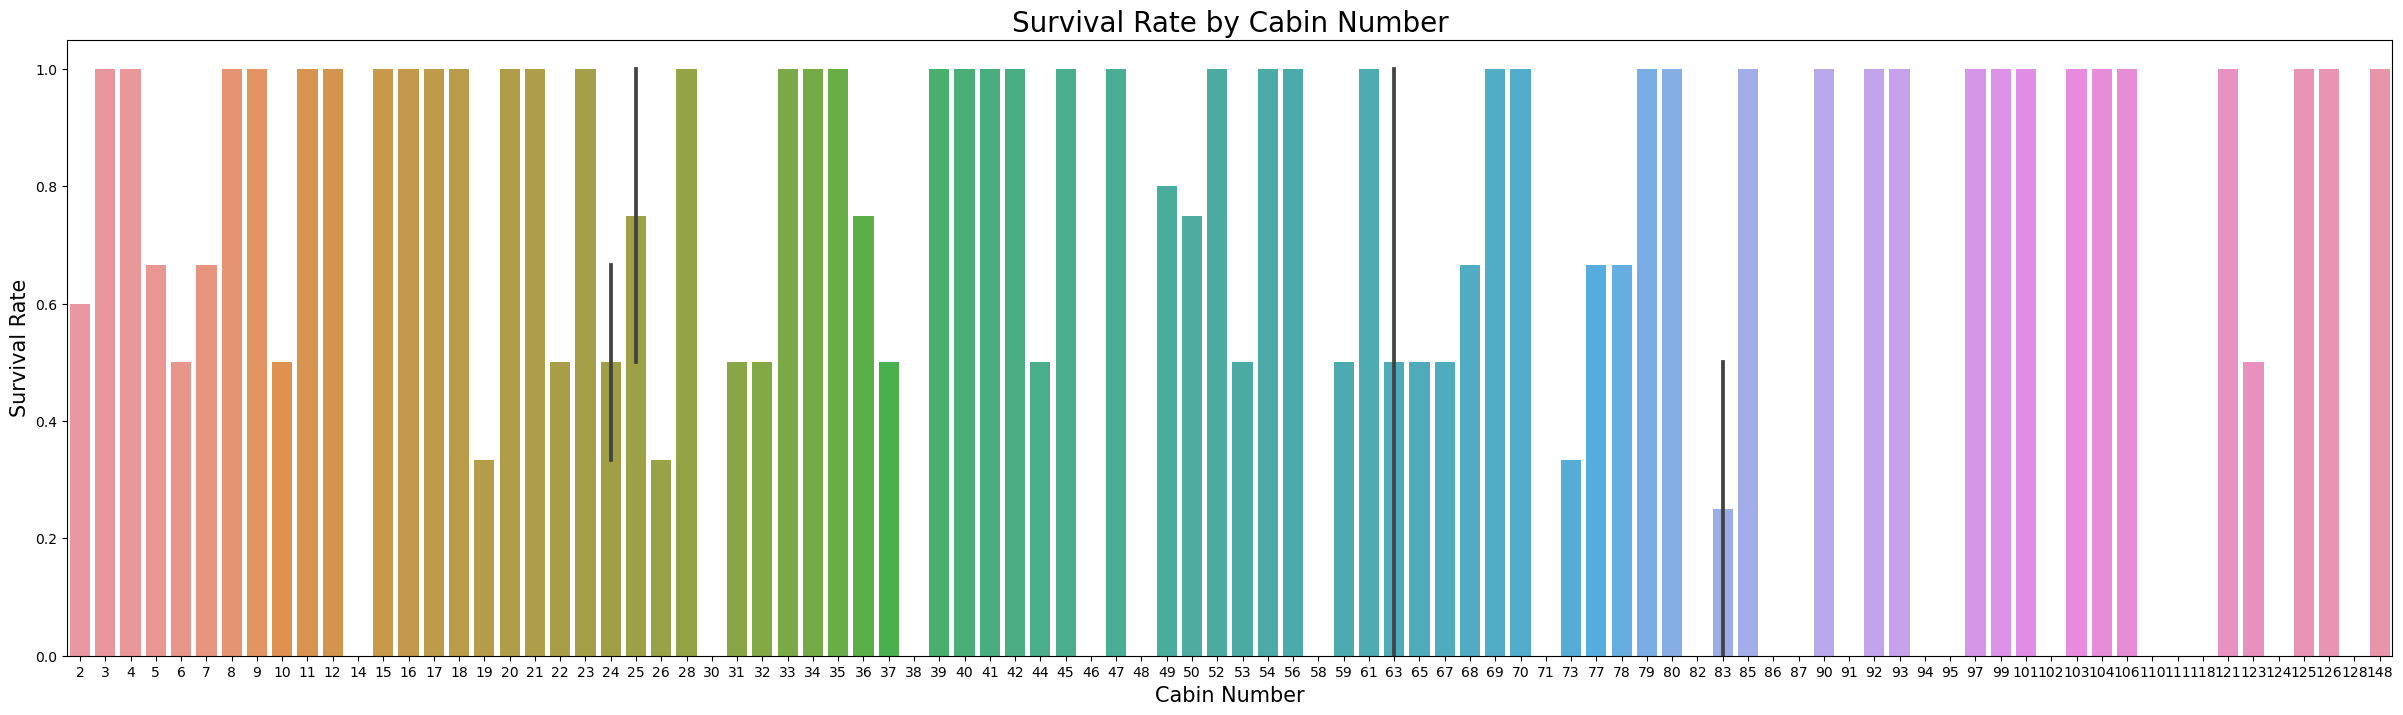

In [56]:
cabin_df = df_train[df_train['CabinNumber'].notna()].copy().groupby('CabinNumber')['Survived'].mean().reset_index()
cabin_df["CabinNumber"] = cabin_df["CabinNumber"].astype(int)

plt.figure(figsize=(30,8))
sns.barplot(x='CabinNumber', y='Survived', data=cabin_df)
plt.xlabel('Cabin Number', fontsize = 15)
plt.ylabel('Survival Rate', fontsize = 15)
plt.title('Survival Rate by Cabin Number', fontsize = 20)
plt.show()

If we look at the mean survival rate for each CabinNumber value, no apparent pattern emerges. This is likely due to the scarcity of CabinNumber data. Let's try again after grouping entries into bins of increments of 25. 

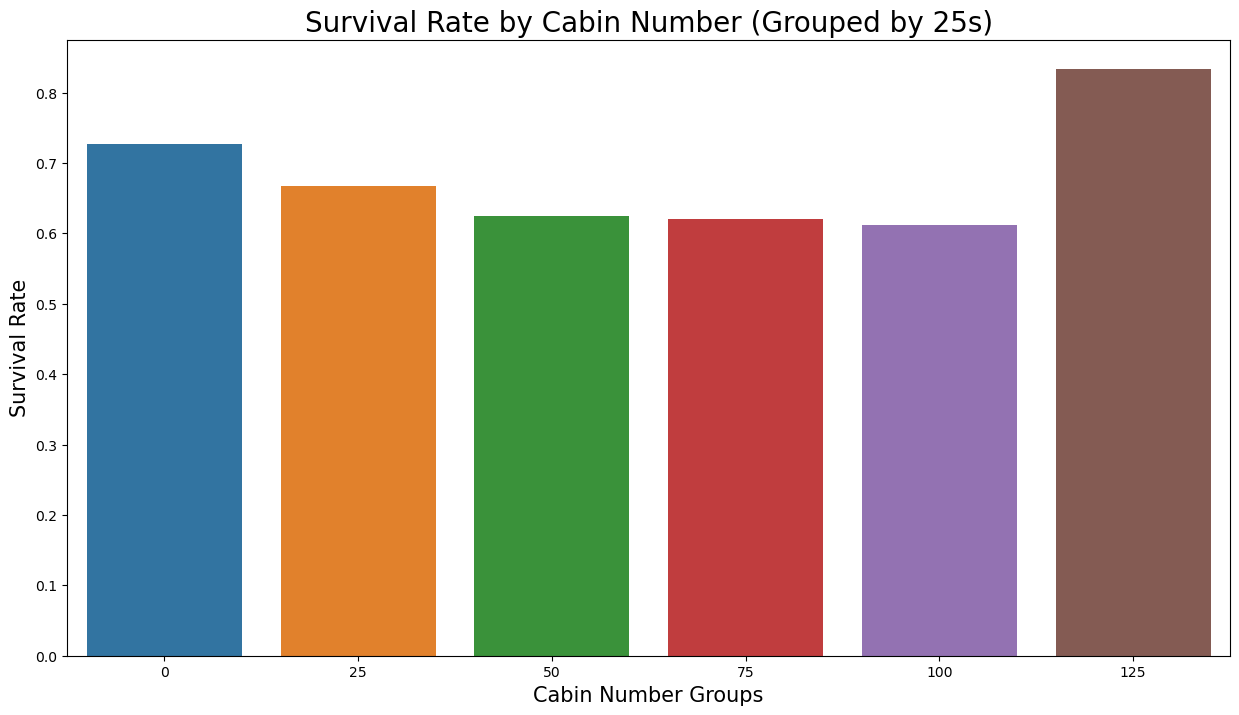

,Headcount,Survival Rate
CabinNumber_Group,,
0,55,0.727273
25,60,0.666667
50,32,0.625000
75,29,0.620690
100,18,0.611111
125,6,0.833333


In [57]:
cabin_df = df_train[df_train['CabinNumber'].notna()].copy()
cabin_df["CabinNumber"] = cabin_df["CabinNumber"].astype(int)
cabin_df["CabinNumber_Group"] = (cabin_df["CabinNumber"] // 25) * 25
cabin_df_plot = cabin_df.groupby('CabinNumber_Group')['Survived'].mean().reset_index()

plt.figure(figsize=(15,8))
sns.barplot(x='CabinNumber_Group', y='Survived', data=cabin_df_plot)
plt.xlabel('Cabin Number Groups', fontsize = 15)
plt.ylabel('Survival Rate', fontsize = 15)
plt.title('Survival Rate by Cabin Number (Grouped by 25s)', fontsize = 20)
plt.show()

cabin_number_groups_stats = cabin_df.groupby("CabinNumber_Group").agg({"Survived" : ["count", "mean"]})
cabin_number_groups_stats.columns = ['_'.join(col) for col in cabin_number_groups_stats.columns]
cabin_number_groups_stats.columns = ["Headcount", "Survival Rate"]
cabin_number_groups_stats

Recognizing that CabinNumber_Group is ordinal, we see that there is a slight negative relationship between survival rate and CabinNumber. (We can disregard the CabinNumber_Group of 125, given its small number of members.) Since we have detected a relationship between CabinNumber and Survival, let's add a CabinNumber_Group feature to our data.

In [58]:
df_train_cabin_number_groups = df_train[df_train["CabinNumber"].notnull()].copy()
df_train_cabin_number_groups["CabinNumber"] = df_train_cabin_number_groups["CabinNumber"].astype(int)
df_train_cabin_number_groups["CabinNumber_Group"] = (df_train_cabin_number_groups["CabinNumber"] // 25) * 25
df_train.loc[df_train_cabin_number_groups.index, "CabinNumber_Group"] = df_train_cabin_number_groups["CabinNumber_Group"]

df_test_cabin_number_groups = df_test[df_test["CabinNumber"].notnull()].copy()
df_test_cabin_number_groups["CabinNumber"] = df_test_cabin_number_groups["CabinNumber"].astype(int)
df_test_cabin_number_groups["CabinNumber_Group"] = (df_test_cabin_number_groups["CabinNumber"] // 25) * 25
df_test.loc[df_test_cabin_number_groups.index, "CabinNumber_Group"] = df_test_cabin_number_groups["CabinNumber_Group"]

### Imputing CabinNumber_Group Classifications: Two Candidate Models

We will employ two candidate models to impute CabinNumber_Group values:
<ul>
    <li><b>Random Forest Classifier:</b> Our old friend, the Random Forest Classifier. It uses multiple Decision Tree Classifiers with random branch architectures. By leveraging randomness, it helps the model avoid overfitting.</li>
    <li><b>Gradient Boosting Classifier:</b> Another ensemble classification method, which iteratively computes the gradients of Decision Tree Classifiers to arrive on a best-fitting model.</li>
</ul>
First we will prepare our data to tune the hyperparameters of these models. Then we will analyze the learning curves for each to determine the best-performing model.

In [59]:
known_cabin = df_train[df_train['CabinNumber_Group'].notna()].copy()
unknown_cabin = df_train[df_train['CabinNumber_Group'].isna()].copy()

features = ['CabinLetter_Cohort', 'Pclass', 'SibSp', 'Parch', 'Fare']
known_cabin_features = known_cabin[features]
known_cabin_targets = known_cabin['CabinNumber_Group']

# Split known data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(known_cabin_features, known_cabin_targets, test_size=0.2, random_state=42)

#### Optimizing RFC and GBC Hyperparameters

In [60]:
model_RFC = RandomForestClassifier(random_state=42)

param_grid_RFC = {
    'n_estimators': [150],
    'max_depth': [6],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
}

model_GBC = GradientBoostingClassifier(random_state=42)

param_grid_GBC = {
    'n_estimators': [100],
    'learning_rate': [0.01],
    'max_depth' : [7],
    'min_samples_split' : [2],
}

models = [(model_RFC, param_grid_RFC, "Random Forest Classifier"),
         (model_GBC, param_grid_GBC, "Gradient Boosting Classifier")]

print("_"*60)
for m in models:
    m_type = m[0]
    m_params = m[1]
    m_name = m[2]
    print(f"Finding hyperparameters for {m_name}...")
    grid_search = GridSearchCV(estimator=m_type, param_grid=m_params, cv=5, scoring='neg_mean_squared_error', verbose=3, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters: ", grid_search.best_params_)
    print("_"*60)

# Change show_trial_log to True to show a log of each hyperparameter tuning trial
show_trial_log = False
if show_trial_log:
    with open("CabinNumber_Group_Hyperparameter_Tuning_Log.txt", "r") as f:
        trial_log = f.read()
    print(trial_log)

____________________________________________________________
Finding hyperparameters for Random Forest Classifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:  {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
____________________________________________________________
Finding hyperparameters for Gradient Boosting Classifier...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters:  {'learning_rate': 0.01, 'max_depth': 7, 'min_samples_split': 2, 'n_estimators': 100}
____________________________________________________________


#### Evaluating the Learning Curve of the Random Forest Classifier and the Gradient Boosting Classifier

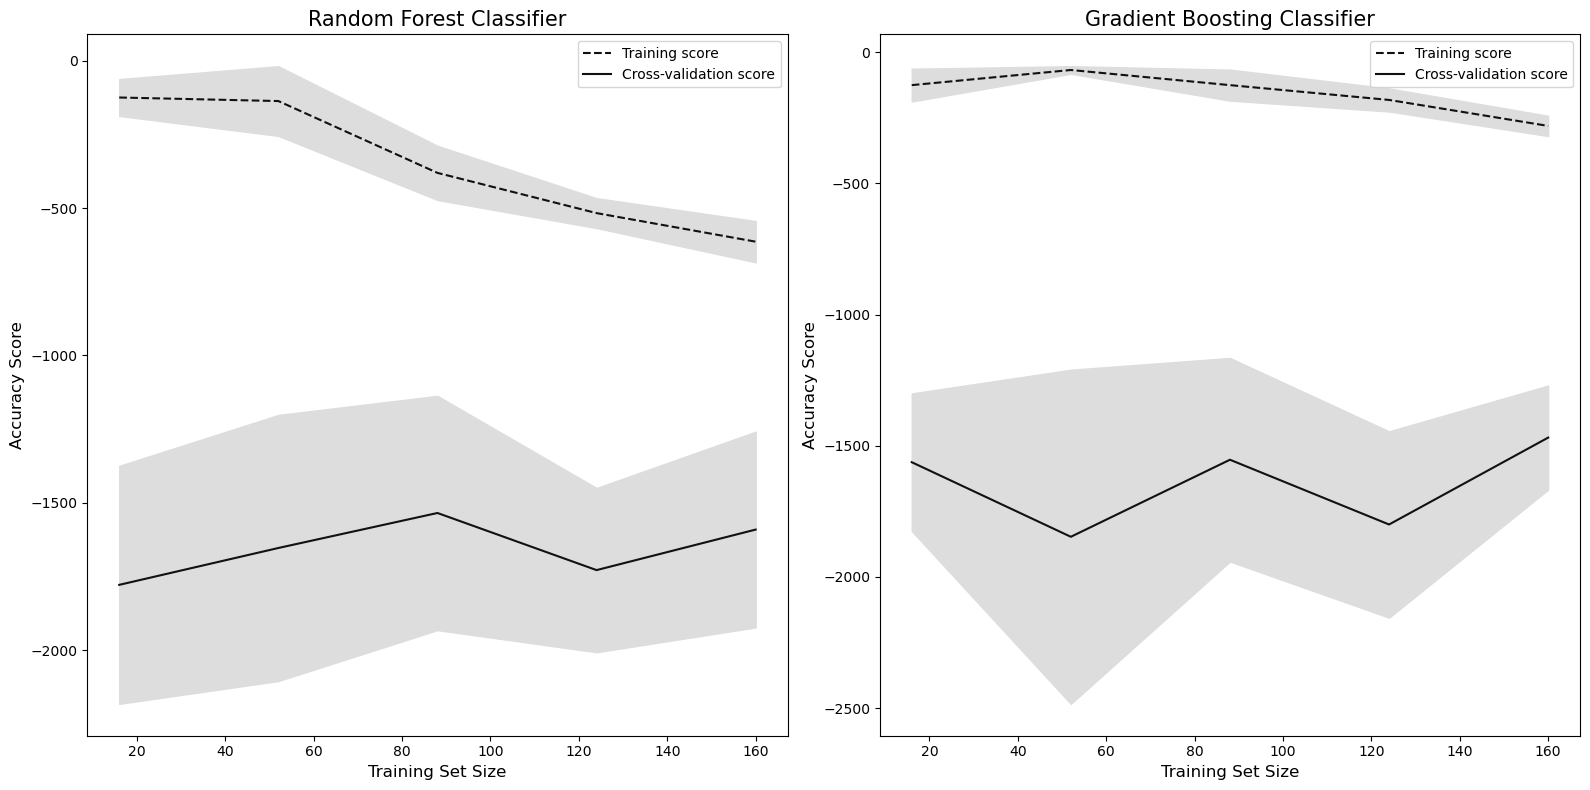

In [61]:
models = [
    {
        'model': RandomForestClassifier(random_state=42, n_estimators=150, max_depth=6, min_samples_split=2, min_samples_leaf=1),
        'name': "Random Forest Classifier"
    },
    {
        'model': GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.01, max_depth=7, min_samples_split=2),
        'name': "Gradient Boosting Classifier"
    }
]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
for i, model_info in enumerate(models):
    lc_results = get_learning_curve_analysis_outputs(model_info['model'],
                                                     known_cabin_features,
                                                     known_cabin_targets,
                                                     cv=5,
                                                     full_name=model_info['name'])
    axes[i].plot(lc_results[0], lc_results[3], '--', color="#111111",  label="Training score")
    axes[i].plot(lc_results[0], lc_results[5], color="#111111", label="Cross-validation score")
    axes[i].fill_between(lc_results[0], lc_results[3] - lc_results[4], lc_results[3] + lc_results[4], color="#DDDDDD")
    axes[i].fill_between(lc_results[0], lc_results[5] - lc_results[6], lc_results[5] + lc_results[6], color="#DDDDDD")
    axes[i].set_title(f"{lc_results[7]}", fontsize = 15)
    axes[i].set_xlabel("Training Set Size", fontsize = 12), axes[i].set_ylabel("Accuracy Score", fontsize = 12), axes[i].legend(loc="best")
plt.tight_layout()
plt.show()

#### Predicting and Assigning CabinLetter_Group Values

Neither the Random Forest Classifier nor the Gradient Boosting Classifier performed spectacularly on the classification task; however, the Random Forest Classifier showed more promising convergence signals and displayed more stability. The lackluster performance is due to the somewhat arbitrary nature of CabinNumber values. We will have to make due with the data we are given, and will assign CabinLetter_Group values according to the predictions made by the Random Forest Classifier.

In [62]:
features = ['CabinLetter_Cohort', 'Pclass', 'SibSp', 'Parch', 'Fare']

model = RandomForestClassifier(random_state = 42, n_estimators = 150, max_depth = 6, min_samples_split = 2, min_samples_leaf = 1)

df_train_known_cng = df_train[df_train["CabinNumber_Group"].notnull()].copy()
df_train_unknown_cng = df_train[df_train["CabinNumber_Group"].isnull()].copy()

X_train = df_train_known_cng[features]
y_train = df_train_known_cng["CabinNumber_Group"]
model.fit(X_train, y_train)

X_test = df_train_unknown_cng[features]
predictions = model.predict(X_test)

df_train.loc[df_train_unknown_cng.index, "CabinNumber_Group"] = predictions

df_test_unknown_cng = df_test[df_test["CabinNumber_Group"].isnull()].copy()
df_test_unknown_cng["Pclass"].fillna(round(df_test["Pclass"].mean()), inplace = True)
df_test_unknown_cng["SibSp"].fillna(round(df_test["SibSp"].mean()), inplace = True)
df_test_unknown_cng["Parch"].fillna(round(df_test["Parch"].mean()), inplace = True)
df_test_unknown_cng["Fare"].fillna(df_test["Fare"].mean(), inplace = True)

X_test_test = df_test_unknown_cng[features]
predictions = model.predict(X_test_test)

df_test.loc[df_test_unknown_cng.index, "CabinNumber_Group"] = predictions

# Conclusion

We have finally arrived upon a fully wrangled dataset. Let's have a look.

In [63]:
df_train.head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NameTitle,CompleteInfo,CabinLetter,CabinNumber,CabinLetter_Cohort,CabinNumber_Group
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",0,22.000,1,0,A/5 21171,7.2500,NaN,S,Mr,0,None,None,4,50.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000,1,0,PC 17599,71.2833,C85,C,Mrs,1,C,85,2,75.0
3,1,3,"Heikkinen, Miss. Laina",1,26.000,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,None,None,4,0.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000,1,0,113803,53.1000,C123,S,Mrs,1,C,123,2,100.0
5,0,3,"Allen, Mr. William Henry",0,35.000,0,0,373450,8.0500,NaN,S,Mr,0,None,None,4,0.0
6,0,3,"Moran, Mr. James",0,23.656,0,0,330877,8.4583,NaN,Q,Mr,0,None,None,4,0.0
7,0,1,"McCarthy, Mr. Timothy J",0,54.000,0,0,17463,51.8625,E46,S,Mr,1,E,46,4,25.0
8,0,3,"Palsson, Master. Gosta Leonard",0,2.000,3,1,349909,21.0750,NaN,S,Master,0,None,None,3,0.0
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27.000,0,2,347742,11.1333,NaN,S,Mrs,0,None,None,4,0.0


## Key Data Wrangling Tasks Performed

In this project, data cleaning consisted of three main tasks:
<ol>
    <li><b>Feature Transformation:</b> Making text-based features numerical through various encoding methods, including binary encoding, dummy variable encoding, and target encoding.</li>
    <li><b>Feature Imputation:</b> The most intensive task of this project. Prediction models were built, evaluated, and employed to predict missing values for key features. Regressors and classifiers were constructed, tuned, evaluated, and compared to ensure that predicted values were high-quality in both the observed training set and hidden test set.</li>
    <li><b>Feature Engineering:</b> Certain patterns were observed in the training set. After ensuring statistical significance among these patterns, new features were added to capture hidden information within the data.</li>
</ol>

## Summary of Feature Modifications

Let's review the modifications made to the features of the data, in order of where the appear in the dataframe:
<ol>
    <li><b>Sex:</b> Transformed to numerical binary values, with 0 indicating male and 1 indicating female.</li>
    <li><b>Age:</b> 177 missing values were predicted using a Random Forest Regressor.</li>
    <li><b>Embarked:</b> 2 missing values were predicted by taking the mode value of this feature.</li>
    <li><b>NameTitle:</b> Engineered from the Name feature. This feature contains the honorific title (ex. "Mrs" or "Rev") contained in each entry's Name value.</li>
    <li><b>CompleteInfo:</b> An engineered numerical binary feature whose value is 0 if a given entry had missing values to begin with or 1 if the entry had no null feature values prior to data wrangling.</li>
    <li><b>CabinLetter:</b> Engineered from the Cabin feature. Contains the letter(s) extracted from an entry's Cabin value.</li>
    <li><b>CabinNumber:</b> Engineered from the Cabin feature. Contains the number (or mean of numbers) extracted from an entry's Cabin value.</li>
    <li><b>CabinLetter_Cohort:</b> Approximately 720 values were imputed via a Gradient Boosting Classifier. This feature was then transformed from text values to numerical values.</li>
    <li><b>CabinNumber_Group:</b> Approximately 720 values were imputed via a Random Forest Classifier.</li>
</ol>

## Summary of Prediction Models and Evaluation Methodologies

This projected employed a variety of prediction models to impute missing Age and Cabin values. In each prediction task, an array of candidate models were developed and evaluated to ensure high-quality predictions were made in the training and test sets, and further, that learning from the observed features generalized well for imputations made in the test set.
<ul>
    <li><b>Regression:</b> To predicted the missing Age values, we experimented with Linear Regression, Decision Tree Regression, and Random Forest Regression models, and performed hyperparameter tuning using grid search CV. Our evaluation process included learning curve analysis and testing two different encoding schemes. The best performance was observed with the Random Forest Regression model using Smoothed Target Encoding.</li>
    <li><b>Classification:</b> For the missing values that were more categorical in nature, CabinLetter_Cohort and CabinNumber_Group, we applied classification methods. Our evaluation metrics included Accuracy, Precision, Recall, and F1 scores. We found that the Gradient Boosting Classifier performed best for one of the features, while the Random Forest Classifier was chosen for the other.</li>
</ul>
In addition to this, we utilized 95% Confidence Interval and Chi-Squared Significance tests, enabling us to make inferences and test hypotheses about our data.<br><br>
The key takeaway from our work is the importance of thorough data preprocessing. Data cleaning and wrangling played a crucial role in the success of our subsequent machine learning models. For future work, further feature engineering and selection could potentially enhance the model's performance. We will continue to monitor the predictive power of the current feature set and explore alternatives as needed.

# Saving the Cleaned Datasets

The next task is to make Survival predictions using this cleaned dataset! All features of the wrangled datasets will be saved, but the features of most interest for the next step are:
<ol>
    <li><b>Pclass</b></li>
    <li><b>Sex</b></li>
    <li><b>Age</b></li>
    <li><b>SibSp</b></li>
    <li><b>Parch</b></li>
    <li><b>Fare</b></li>
    <li><b>NameTitle:</b> <i>categorical/text-based; will likely require numerical encoding.</i></li>
    <li><b>CompleteInfo</b></li>
    <li><b>CabinLetter_Cohort</b></li>
    <li><b>CabinNumber_Group</b></li>
    <li><b>Embarked</b> <i>categorical/text-based; will likely require numerical encoding; usefulness to prediction task is uncertain and will need to be evaluated in context of prediction model.</i></li>
</ol>
Let's save the datasets as CSVs!

In [64]:
# Exporting the cleaned Training set
df_train.to_csv('Titanic_Train_Cleaned.csv', index=True)

# Exporting the cleaned Test set
df_test.to_csv('Titanic_Test_Cleaned.csv', index=True)

# Thanks for Viewing!

I'd love to hear your feedback! Please feel free to fork this project and edit it how you please! If you'd like to pass along any suggestions, you can contact me at christianevans0226@gmail.com!